In [1]:
import itertools
import re
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from IPython.display import Image
from mne.time_frequency import tfr_morlet
from scipy.stats import f_oneway, kruskal
from utils import preprocess_eeg_data, process_variable_time_epochs

In [4]:
EEG_DATA_DIR = Path("../../eeg_data")

In [3]:
all_epochs = []
for dir in EEG_DATA_DIR.iterdir():
    if dir.is_dir():
        preprocessed_data = preprocess_eeg_data(
            dir_path=dir, l_freq=1.0, h_freq=50.0, notch_filter=[50, 100]
        )
        epochs, *_ = process_variable_time_epochs(
            preprocessed_data, baseline=(None, None), constant_values=0
        )

        for epoch in epochs:
            epoch_dct = epoch.to_dict()
            epoch_dct["participant_id"] = dir.stem
            all_epochs.append(epoch_dct)

In [4]:
def block_to_readable_name(block_name):
    response_type, identity = re.fullmatch(
        r"(.+)_RESPONSE_TO_(.+)_IDENTITY", block_name
    ).groups()

    return f"{response_type} / {identity}"

In [5]:
df = pd.DataFrame(all_epochs)
df["experiment_block"] = df["experiment_block"].apply(block_to_readable_name)
df["duration"] = df["duration"].apply(lambda x: x * 1000)

df.head()

,experiment_block,epochs,personal_data_field,personal_data_type,response,correct_response,duration,participant_id
0,HONEST / TRUE,"<Epochs | 1 events (all good), 0 – 0.832 s, b...",NAME,REAL,YES,YES,832.0,02F6BC66
1,HONEST / TRUE,"<Epochs | 1 events (all good), 0 – 1.004 s, b...",BIRTH_DATE,CELEBRITY,YES,YES,1004.0,02F6BC66
2,HONEST / TRUE,"<Epochs | 1 events (all good), 0 – 0.676 s, b...",NAME,RANDO,NO,NO,676.0,02F6BC66
3,HONEST / TRUE,"<Epochs | 1 events (all good), 0 – 0.98 s, ba...",HOMETOWN,RANDO,NO,NO,980.0,02F6BC66
4,HONEST / TRUE,"<Epochs | 1 events (all good), 0 – 0.7 s, bas...",NAME,RANDO,NO,NO,700.0,02F6BC66


In [6]:
questionnaires = pd.read_excel("../eeg_data/Ankiety.xlsx")

questionnaires.head()

,UUID,Płeć,Wiek
0,02F6BC66,M,22
1,1299BF1A,K,23
2,2D663E30,M,22
3,4C0F44CF,M,25
4,827366EC,M,22


# Czas odpowiedzi

In [7]:
df["duration"].mean()

np.float64(677.8080281451862)

średni czas odpowiedzi: ~678 ms

w pracy dla honest/true 494 ms, pozostałe ok. 550 ms

In [8]:
relevant_data = df[
    (df["personal_data_type"].isin(("REAL", "FAKE"))) & (df["response"] != "TIMEOUT")
]

In [9]:
by_block = relevant_data[["experiment_block", "duration"]].groupby(["experiment_block"])

by_block.describe()

duration                                                     \
                    count        mean         std      min      25%      50%   
experiment_block                                                               
DECEITFUL / FAKE    675.0  732.503920  248.320814  388.000  578.003  648.010   
DECEITFUL / TRUE    675.0  645.505111  189.729123  360.001  535.996  599.999   
HONEST / FAKE       675.0  649.576179  206.197779  391.999  520.005  592.011   
HONEST / TRUE       675.0  612.177597  154.199963  371.994  519.997  579.998   

                                      
                       75%       max  
experiment_block                      
DECEITFUL / FAKE  804.0005  1944.001  
DECEITFUL / TRUE  686.0030  1860.001  
HONEST / FAKE     698.0020  1811.996  
HONEST / TRUE     659.9945  1703.994

dla tylko danych, które nas interesują, bez timeoutów:
- średnio najszybsze honest/true
- średnio najwolniejsze deceitful/fake
- deceitful/true minimalnie szybsze od honest/fake

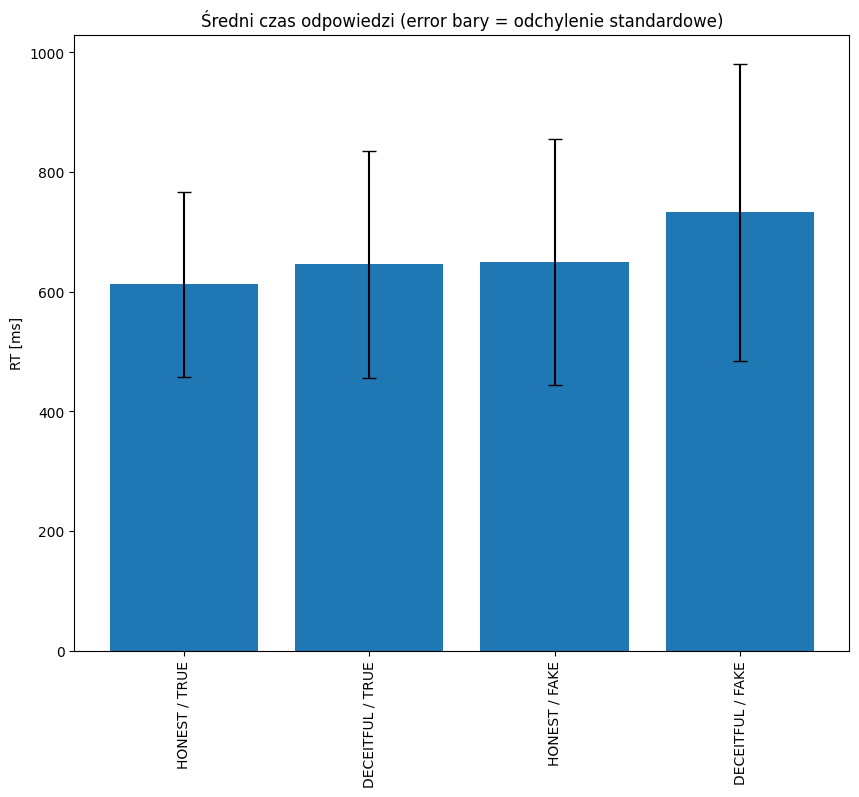

In [10]:
by_block_agg = (
    by_block["duration"]
    .agg(["mean", "std", "sem"])
    .reindex(("HONEST / TRUE", "DECEITFUL / TRUE", "HONEST / FAKE", "DECEITFUL / FAKE"))
)

plt.figure(figsize=(10, 8))
plt.bar(by_block_agg.index, by_block_agg["mean"], yerr=by_block_agg["std"], capsize=5)
plt.xticks(rotation=90)
plt.ylabel("RT [ms]")
plt.title("Średni czas odpowiedzi (error bary = odchylenie standardowe)")

None

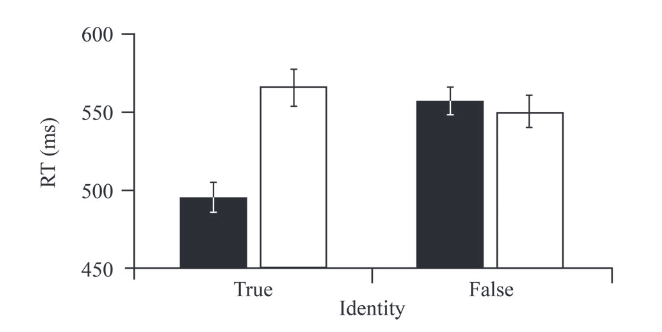

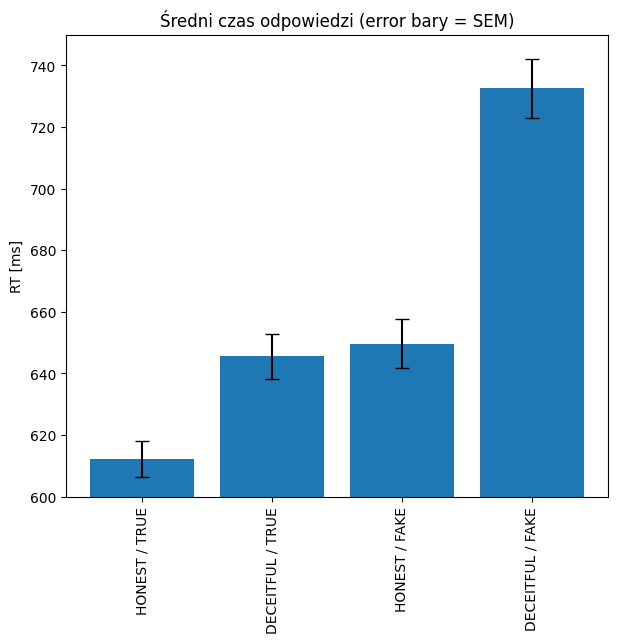

In [11]:
plt.figure(figsize=(7, 6))
plt.bar(by_block_agg.index, by_block_agg["mean"], yerr=by_block_agg["sem"], capsize=5)
plt.xticks(rotation=90)
plt.ylabel("RT [ms]")
plt.ylim(600, 750)
plt.title("Średni czas odpowiedzi (error bary = SEM)")

Image(filename="figure1.png")

In [12]:
blocks = relevant_data["experiment_block"].unique()
filtered_by_blocks = {}
for block in blocks:
    filtered_by_block = relevant_data[relevant_data["experiment_block"] == block]

    filtered_by_blocks[block] = list(filtered_by_block["duration"])

print("WSZYSTKIE:")
all_blocks = filtered_by_blocks.values()
display(f_oneway(*all_blocks))
# display(kruskal(*all_blocks))


print()
print("PARAMI:")
print()
for first, second in itertools.combinations(blocks, 2):
    pair_blocks = [filtered_by_blocks[first], filtered_by_blocks[second]]

    print(first, ",", second)
    display(f_oneway(*pair_blocks))
    # display(kruskal(*pair_blocks))

WSZYSTKIE:


F_onewayResult(statistic=np.float64(43.159815510249), pvalue=np.float64(3.0865705146337036e-27))


PARAMI:

HONEST / TRUE , DECEITFUL / TRUE


F_onewayResult(statistic=np.float64(12.54271950119089), pvalue=np.float64(0.0004113102843260034))

HONEST / TRUE , DECEITFUL / FAKE


F_onewayResult(statistic=np.float64(114.38247150421299), pvalue=np.float64(1.1131276557835722e-25))

HONEST / TRUE , HONEST / FAKE


F_onewayResult(statistic=np.float64(14.240730734899342), pvalue=np.float64(0.000167832197370644))

DECEITFUL / TRUE , DECEITFUL / FAKE


F_onewayResult(statistic=np.float64(52.31329008583816), pvalue=np.float64(7.908409304559641e-13))

DECEITFUL / TRUE , HONEST / FAKE


F_onewayResult(statistic=np.float64(0.14248519454328604), pvalue=np.float64(0.7058822073892947))

DECEITFUL / FAKE , HONEST / FAKE


F_onewayResult(statistic=np.float64(44.557001488271624), pvalue=np.float64(3.5996553020745896e-11))

statystycznie znaczącej różnicy nie ma tylko dla pary DECEITFUL / TRUE & HONEST / FAKE

w pracy dla TRUE pomiędzy HONEST a DECEITFUL była różnica 71 ms, u nas 34 ms

to ma jakiś tam sens: swoje dane rozpoznajesz od razu, nawet jak musisz na ich temat kłamać

a fejkowe dane trzeba było rozpoznać wśród danych celebryty/randoma, więc nawet mówienie prawdy na ich temat było wolniejsze

In [13]:
with_is_truth = relevant_data.copy()
with_is_truth["is_truth"] = with_is_truth["experiment_block"].apply(
    lambda x: x.startswith("HONEST")
)

by_participant = with_is_truth[["participant_id", "is_truth", "duration"]].groupby(
    ["participant_id", "is_truth"]
)
by_participant_agg = (
    by_participant["duration"]
    .agg(["mean", "std"])
    .reset_index()
    .pivot_table(index="participant_id", columns="is_truth", values=["mean", "std"])
)

by_participant_agg.columns = [
    f'{value}_{"truth" if is_truth else "lie"}'
    for value, is_truth in by_participant_agg.columns
]

by_participant_agg.head()

,mean_lie,mean_truth,std_lie,std_truth
participant_id,,,,
02F6BC66,1005.912344,896.132244,321.164056,316.573353
1299BF1A,648.222489,643.688689,129.312651,138.853085
2D663E30,710.755556,713.466489,151.746823,170.735600
4C0F44CF,679.200489,669.334033,146.940894,141.956869
827366EC,826.755900,585.688922,321.407967,124.672250


In [14]:
with_is_truth.groupby(["is_truth"]).describe()

duration                                                        \
            count        mean         std      min        25%       50%   
is_truth                                                                  
False      1350.0  689.004516  225.139039  360.001  552.00100  624.0005   
True       1350.0  630.876888  182.956080  371.994  520.00175  584.0000   

                             
              75%       max  
is_truth                     
False     743.999  1944.001  
True      676.000  1811.996

In [15]:
all_mean = 0.6778080281451861 * 1000

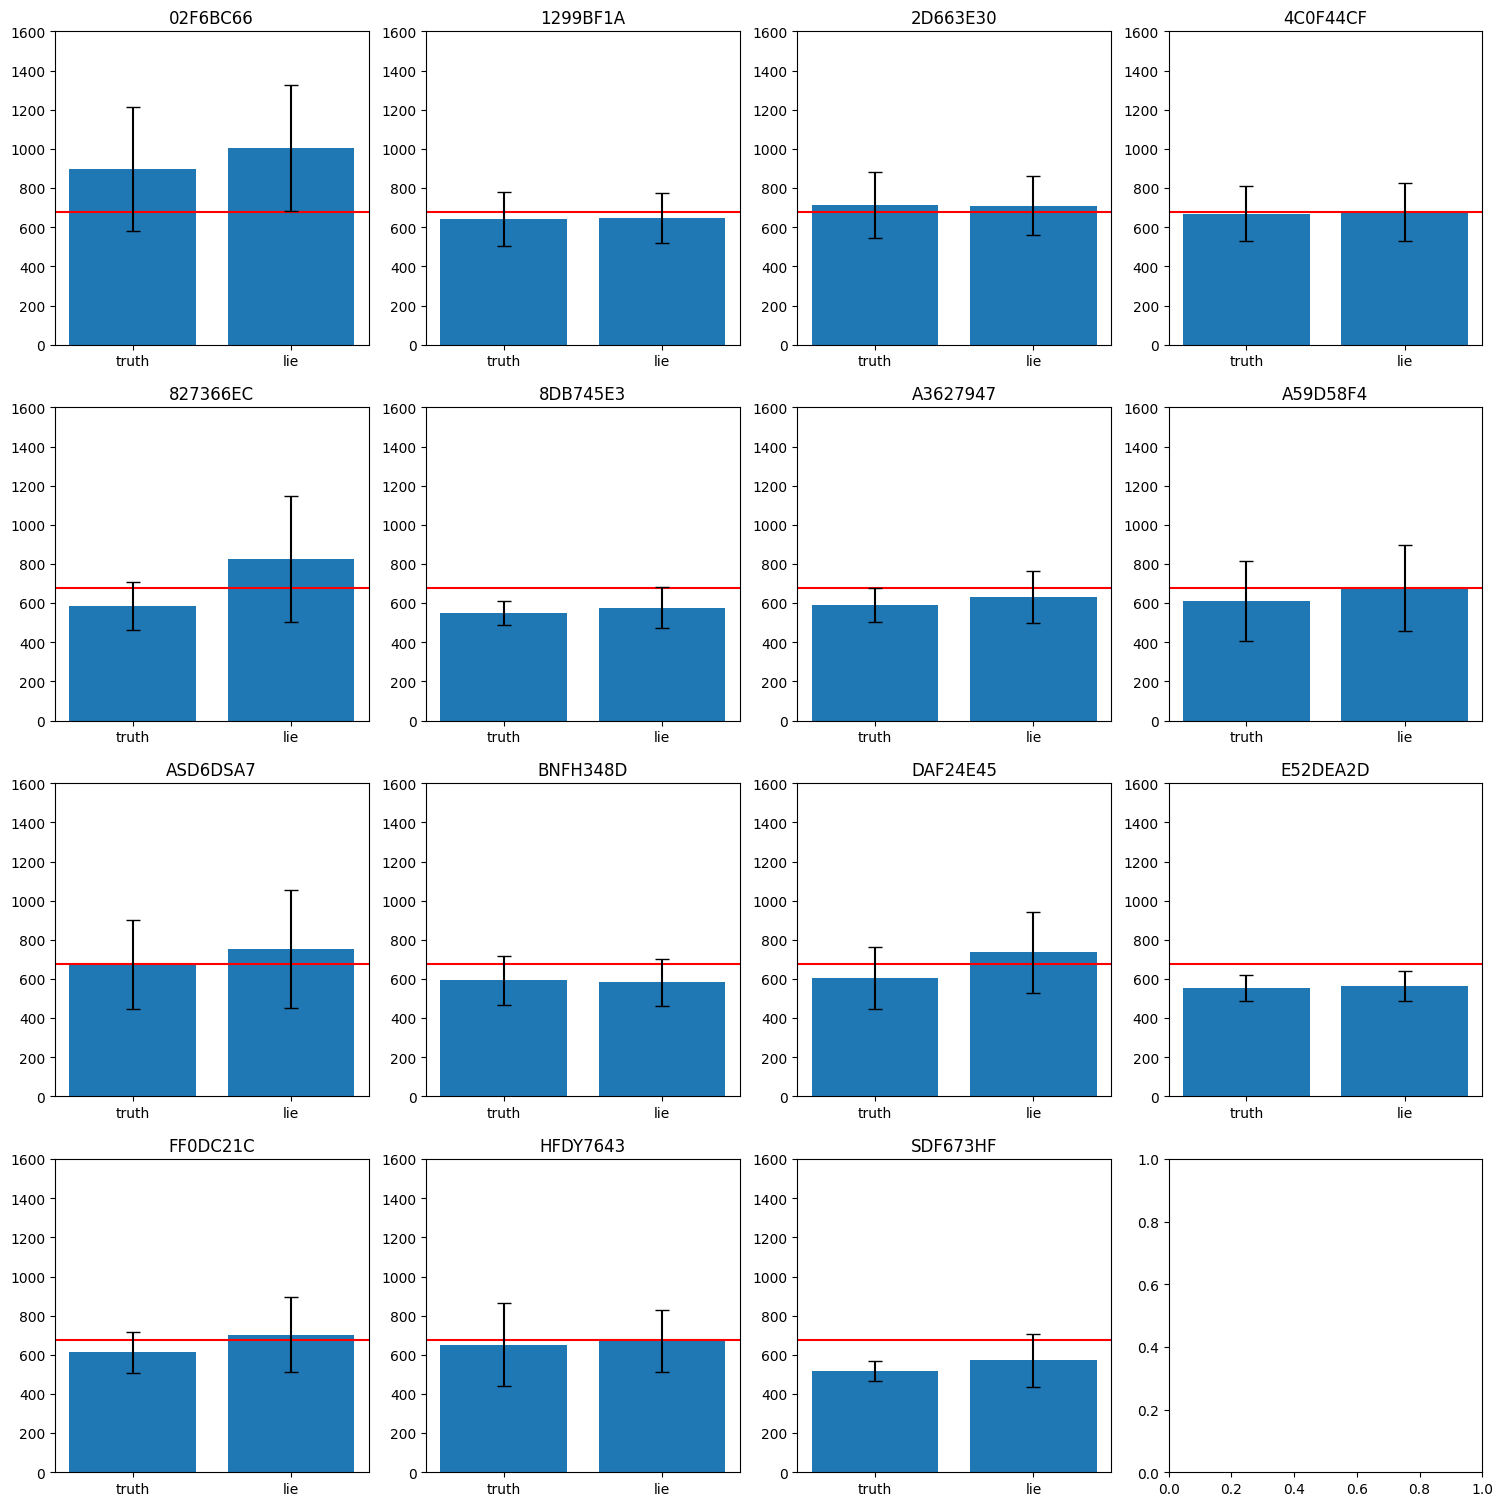

In [16]:
fig, nested_axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)
axes = [ax for subax in nested_axes for ax in subax]

for participant, ax in zip(by_participant_agg.iterrows(), axes):
    mean_lie, mean_truth, std_lie, std_truth = participant[1]

    xs = ["truth", "lie"]
    ys = [mean_truth, mean_lie]
    errs = [std_truth, std_lie]

    ax.axhline(y=all_mean, color="r")
    ax.set_ylim(0, 1600)
    ax.bar(xs, ys, yerr=errs, capsize=5)
    ax.set_title(participant[0])

In [17]:
all_data_no_timeouts = df[df["response"] != "TIMEOUT"]

In [18]:
by_data_type = all_data_no_timeouts[["personal_data_type", "duration"]].groupby(
    ["personal_data_type"]
)

by_data_type.describe()

duration                                              \
                      count        mean         std      min        25%   
personal_data_type                                                        
CELEBRITY            1890.0  654.810468  192.561455  356.003  536.00300   
FAKE                 1350.0  691.040050  231.888526  388.000  548.00175   
RANDO                1890.0  710.810661  222.721578  376.007  567.99300   
REAL                 1350.0  628.841354  173.617729  360.001  531.99700   

                                                   
                         50%        75%       max  
personal_data_type                                 
CELEBRITY           611.9990  711.99625  2000.000  
FAKE                616.0130  751.99500  1944.001  
RANDO               648.0015  779.99900  1983.994  
REAL                585.9985  668.02625  1860.001

In [19]:
by_data_type_and_block = all_data_no_timeouts[
    ["experiment_block", "personal_data_type", "duration"]
].groupby(["experiment_block", "personal_data_type"])

by_data_type_and_block.describe()

duration                                   \
                                       count        mean         std      min   
experiment_block personal_data_type                                             
DECEITFUL / FAKE CELEBRITY             135.0  700.059304  188.451185  435.997   
                 FAKE                  675.0  732.503920  248.320814  388.000   
                 RANDO                 810.0  747.466756  248.675640  388.000   
DECEITFUL / TRUE CELEBRITY             810.0  660.597221  194.981976  388.000   
                 RANDO                 135.0  708.948081  222.740090  455.993   
                 REAL                  675.0  645.505111  189.729123  360.001   
HONEST / FAKE    CELEBRITY             810.0  622.404930  179.232768  356.003   
                 FAKE                  675.0  649.576179  206.197779  391.999   
                 RANDO                 135.0  722.163659  255.557155  376.007   
HONEST / TRUE    CELEBRITY             135.0  769.274348  204.739388  416.001   
                 RANDO                 810.0  672.572831  179.221110  380.005   
                 REAL                  675.0  612.177597  154.199963  371.994   

                                                                               
                                           25%       50%        75%       max  
experiment_block personal_data_type                                            
DECEITFUL / FAKE CELEBRITY           583.99900  648.0110  746.00050  1792.000  
                 FAKE                578.00300  648.0100  804.00050  1944.001  
                 RANDO               579.98975  680.0000  834.99875  1940.002  
DECEITFUL / TRUE CELEBRITY           539.99400  615.9970  715.99025  2000.000  
                 RANDO               578.00250  647.9950  759.99750  1983.994  
                 REAL                535.99600  599.9990  686.00300  1860.001  
HONEST / FAKE    CELEBRITY           520.00400  584.0000  667.99900  1995.999  
                 FAKE                520.00500  592.0110  698.00200  1811.996  
                 RANDO               559.99750  631.9960  792.00400  1815.995  
HONEST / TRUE    CELEBRITY           636.00550  727.9970  865.99700  1592.010  
                 RANDO               553.00150  628.0005  732.00275  1672.000  
                 REAL                519.99700  579.9980  659.99450  1703.994

- REAL najkrótsze

- potem CELEBRITY (najbardziej rozpoznawalna dana), oprócz HONEST/TRUE
    - dziwne bo w tym bloku odpowiedź NO była tylko na RANDO, a na CELEBRITY i REAL - YES; może przez to że pierwszy blok

- najdłuższe RANDO

In [20]:
by_field = all_data_no_timeouts[["personal_data_field", "duration"]].groupby(
    ["personal_data_field"]
)

by_field.describe()

duration                                              \
                       count        mean         std      min        25%   
personal_data_field                                                        
BIRTH_DATE            2160.0  683.911091  205.233579  356.003  552.00200   
HOMETOWN              2160.0  680.403598  217.282750  367.997  548.00325   
NAME                  2160.0  655.529677  203.540633  360.001  532.00075   

                                                   
                         50%        75%       max  
personal_data_field                                
BIRTH_DATE           630.005  744.00400  1843.994  
HOMETOWN             619.995  737.00350  1983.994  
NAME                 600.006  700.00025  2000.000

In [21]:
by_data_field_and_block = all_data_no_timeouts[
    ["experiment_block", "personal_data_field", "duration"]
].groupby(["experiment_block", "personal_data_field"])

by_data_field_and_block.describe()

duration                          \
                                        count        mean         std   
experiment_block personal_data_field                                    
DECEITFUL / FAKE BIRTH_DATE             540.0  715.407800  220.974859   
                 HOMETOWN               540.0  752.703754  266.308540   
                 NAME                   540.0  743.733306  242.436467   
DECEITFUL / TRUE BIRTH_DATE             540.0  685.755298  205.451957   
                 HOMETOWN               540.0  661.607043  204.194922   
                 NAME                   540.0  627.651900  172.196895   
HONEST / FAKE    BIRTH_DATE             540.0  640.829669  187.317588   
                 HOMETOWN               540.0  649.621828  191.099961   
                 NAME                   540.0  635.667037  219.479154   
HONEST / TRUE    BIRTH_DATE             540.0  693.651596  199.092081   
                 HOMETOWN               540.0  657.681769  181.431690   
                 NAME                   540.0  615.066465  136.890257   

                                                                               \
                                          min        25%       50%        75%   
experiment_block personal_data_field                                            
DECEITFUL / FAKE BIRTH_DATE           388.000  568.00100  660.0040  791.99400   
                 HOMETOWN             407.998  580.00200  660.0015  836.99750   
                 NAME                 404.007  596.00100  673.9960  818.00125   
DECEITFUL / TRUE BIRTH_DATE           419.998  559.99800  631.9920  727.99850   
                 HOMETOWN             367.997  535.99600  612.0000  713.00350   
                 NAME                 360.001  527.99975  592.0065  676.01000   
HONEST / FAKE    BIRTH_DATE           356.003  528.00000  596.0005  687.99075   
                 HOMETOWN             372.009  539.00200  600.0040  700.00075   
                 NAME                 376.000  515.99900  568.0085  675.99975   
HONEST / TRUE    BIRTH_DATE           403.992  563.99825  647.9950  764.00000   
                 HOMETOWN             371.994  536.00300  612.0000  712.00600   
                 NAME                 376.004  530.98725  584.0000  665.00125   

                                                
                                           max  
experiment_block personal_data_field            
DECEITFUL / FAKE BIRTH_DATE           1756.012  
                 HOMETOWN             1944.001  
                 NAME                 1839.996  
DECEITFUL / TRUE BIRTH_DATE           1843.994  
                 HOMETOWN             1983.994  
                 NAME                 2000.000  
HONEST / FAKE    BIRTH_DATE           1811.996  
                 HOMETOWN             1815.995  
                 NAME                 1995.999  
HONEST / TRUE    BIRTH_DATE           1703.994  
                 HOMETOWN             1627.991  
                 NAME                 1500.000

najkrótsze NAME

oprócz w bloku DECEITFUL/FAKE, gdzie BIRTH_DATE było szybsze od imienia i nazwiska(?)

jakbyśmy nie usuwali danych badanych to można by zrobić analizę na zasadzie "tu ktoś odpowiadał wolniej bo miał podobne imię"

In [22]:
by_field_relevant_data = relevant_data[["personal_data_field", "duration"]].groupby(
    ["personal_data_field"]
)

by_field_relevant_data.describe()

duration                                              \
                       count        mean         std      min        25%   
personal_data_field                                                        
BIRTH_DATE             900.0  658.706546  194.180286  388.000  538.99750   
HOMETOWN               900.0  678.382081  229.475067  367.997  539.00875   
NAME                   900.0  642.733479  194.477038  360.001  524.00200   

                                                   
                         50%        75%       max  
personal_data_field                                
BIRTH_DATE           604.004  712.00200  1811.996  
HOMETOWN             612.000  736.00200  1944.001  
NAME                 599.991  684.00525  1839.996

HOMETOWN najdłużej, IMO błąd że tam się losował Wrocław jako pierwszy

In [23]:
by_field_and_block_relevant_data = relevant_data[
    ["experiment_block", "personal_data_field", "duration"]
].groupby(["experiment_block", "personal_data_field"])

by_field_and_block_relevant_data.describe()

duration                          \
                                        count        mean         std   
experiment_block personal_data_field                                    
DECEITFUL / FAKE BIRTH_DATE             225.0  686.685196  207.398102   
                 HOMETOWN               225.0  762.577387  279.421463   
                 NAME                   225.0  748.249178  247.353431   
DECEITFUL / TRUE BIRTH_DATE             225.0  666.737360  205.279943   
                 HOMETOWN               225.0  665.671129  223.862724   
                 NAME                   225.0  604.106844  116.084784   
HONEST / FAKE    BIRTH_DATE             225.0  640.052902  200.608144   
                 HOMETOWN               225.0  669.599591  211.678578   
                 NAME                   225.0  639.076044  205.611711   
HONEST / TRUE    BIRTH_DATE             225.0  641.350724  156.295575   
                 HOMETOWN               225.0  615.680218  164.415469   
                 NAME                   225.0  579.501849  134.702516   

                                                                          \
                                          min      25%      50%      75%   
experiment_block personal_data_field                                       
DECEITFUL / FAKE BIRTH_DATE           388.000  552.002  616.001  760.002   
                 HOMETOWN             407.998  583.999  652.008  856.003   
                 NAME                 416.000  599.998  667.999  807.998   
DECEITFUL / TRUE BIRTH_DATE           419.998  543.991  611.999  695.999   
                 HOMETOWN             367.997  531.998  600.006  708.000   
                 NAME                 360.001  531.998  591.996  664.002   
HONEST / FAKE    BIRTH_DATE           419.998  516.007  584.000  691.998   
                 HOMETOWN             391.999  536.003  612.000  728.012   
                 NAME                 404.007  519.989  587.997  675.999   
HONEST / TRUE    BIRTH_DATE           403.992  548.004  612.000  691.986   
                 HOMETOWN             371.994  516.002  580.000  652.001   
                 NAME                 376.004  500.000  552.002  627.990   

                                                
                                           max  
experiment_block personal_data_field            
DECEITFUL / FAKE BIRTH_DATE           1756.012  
                 HOMETOWN             1944.001  
                 NAME                 1839.996  
DECEITFUL / TRUE BIRTH_DATE           1608.001  
                 HOMETOWN             1860.001  
                 NAME                 1136.001  
HONEST / FAKE    BIRTH_DATE           1811.996  
                 HOMETOWN             1776.001  
                 NAME                 1655.999  
HONEST / TRUE    BIRTH_DATE           1703.994  
                 HOMETOWN             1627.991  
                 NAME                 1363.998

In [24]:
deceitful_fake_by_field_and_block_relevant_data = relevant_data[
    relevant_data["experiment_block"] == "DECEITFUL / FAKE"
][["participant_id", "personal_data_field", "duration"]].groupby(
    ["participant_id", "personal_data_field"]
)

means = deceitful_fake_by_field_and_block_relevant_data["duration"].mean().reset_index()
with_order = (
    means.groupby("participant_id")
    .apply(
        lambda x: x.sort_values(by="duration")["personal_data_field"].tolist(),
        include_groups=False,
    )
    .reset_index()
)
with_order.columns = ["participant_id", "order"]

with_order["order"].value_counts()

order
[BIRTH_DATE, HOMETOWN, NAME]    6
[BIRTH_DATE, NAME, HOMETOWN]    4
[NAME, BIRTH_DATE, HOMETOWN]    2
[HOMETOWN, BIRTH_DATE, NAME]    2
[HOMETOWN, NAME, BIRTH_DATE]    1
Name: count, dtype: int64

akurat w tym bloku najszybsze było BIRTH_DATE

In [25]:
all_data_with_personal_data = pd.merge(
    all_data_no_timeouts,
    questionnaires,
    how="inner",
    left_on="participant_id",
    right_on="UUID",
)

all_data_with_personal_data[all_data_with_personal_data["Wiek"].isnull()]

,experiment_block,epochs,personal_data_field,personal_data_type,response,correct_response,duration,participant_id,UUID,Płeć,Wiek


In [26]:
relevant_data_with_personal_data = pd.merge(
    relevant_data,
    questionnaires,
    how="inner",
    left_on="participant_id",
    right_on="UUID",
)

relevant_data_with_personal_data[relevant_data_with_personal_data["Wiek"].isnull()]

,experiment_block,epochs,personal_data_field,personal_data_type,response,correct_response,duration,participant_id,UUID,Płeć,Wiek


In [27]:
by_sex = all_data_with_personal_data[["Płeć", "duration"]].groupby(["Płeć"])

by_sex.describe()

duration                                                                  \
        count        mean         std      min       25%       50%        75%   
Płeć                                                                            
K      3456.0  642.715185  175.188263  356.003  536.0085  600.0060  688.00100   
M      3024.0  708.214336  237.413478  360.001  552.0000  644.0005  783.99625   

                
           max  
Płeć            
K     1944.001  
M     2000.000

In [28]:
relevant_data_by_sex = relevant_data_with_personal_data[["Płeć", "duration"]].groupby(
    ["Płeć"]
)

relevant_data_by_sex.describe()

duration                                                                  \
        count        mean         std      min        25%      50%        75%   
Płeć                                                                            
K      1440.0  635.202706  175.976103  367.997  535.99500  595.993  668.00375   
M      1260.0  688.212698  234.719709  360.001  535.99825  625.999  756.00675   

                
           max  
Płeć            
K     1944.001  
M     1860.001

In [29]:
relevant_data_by_sex = relevant_data_with_personal_data[
    ["experiment_block", "Płeć", "duration"]
].groupby(["experiment_block", "Płeć"])

relevant_data_by_sex.describe()

duration                                              \
                         count        mean         std      min        25%   
experiment_block Płeć                                                        
DECEITFUL / FAKE K       360.0  685.844817  224.471354  388.000  559.99775   
                 M       315.0  785.828610  263.444157  403.999  608.00200   
DECEITFUL / TRUE K       360.0  624.299881  137.108746  367.997  535.99825   
                 M       315.0  669.739660  233.816428  360.001  534.00400   
HONEST / FAKE    K       360.0  614.822228  167.311316  404.007  516.00000   
                 M       315.0  689.294981  237.258336  391.999  535.99600   
HONEST / TRUE    K       360.0  615.843897  153.188008  388.001  532.00400   
                 M       315.0  607.987540  155.486243  371.994  503.99800   

                                                     
                            50%       75%       max  
experiment_block Płeć                                
DECEITFUL / FAKE K     615.9975  740.0005  1944.001  
                 M     715.9990  883.9980  1839.996  
DECEITFUL / TRUE K     596.0085  672.9970  1315.995  
                 M     600.0060  701.9980  1860.001  
HONEST / FAKE    K     567.9970  648.0100  1811.996  
                 M     632.0000  749.9920  1776.001  
HONEST / TRUE    K     583.9915  648.0040  1703.994  
                 M     568.0010  667.9990  1411.987

kobiety odpowiadały szybciej wszędzie oprócz HONEST / TRUE

In [30]:
relevant_data_by_sex_and_type = all_data_with_personal_data[
    ["personal_data_type", "Płeć", "duration"]
].groupby(["personal_data_type", "Płeć"])

relevant_data_by_sex_and_type.describe()

duration                                              \
                           count        mean         std      min        25%   
personal_data_type Płeć                                                        
CELEBRITY          K      1008.0  615.714050  149.563977  356.003  531.99700   
                   M       882.0  699.492090  224.028648  391.998  552.00000   
FAKE               K       720.0  650.333522  200.993861  388.000  535.99500   
                   M       630.0  737.561795  255.109083  391.999  568.00025   
RANDO              K      1008.0  680.448434  190.898864  376.007  563.99500   
                   M       882.0  745.510350  249.892048  399.994  568.00275   
REAL               K       720.0  620.071889  145.331332  367.997  535.99500   
                   M       630.0  638.863600  200.786498  360.001  516.00700   

                                                        
                              50%        75%       max  
personal_data_type Płeć                                 
CELEBRITY          K     584.0000  664.00100  1620.003  
                   M     647.9995  776.00100  2000.000  
FAKE               K     596.0080  692.99750  1944.001  
                   M     667.9990  812.00325  1839.996  
RANDO              K     631.9960  732.00125  1824.002  
                   M     679.9930  828.00300  1983.994  
REAL               K     587.9970  664.00000  1703.994  
                   M     584.0150  690.99050  1860.001

kobiety najszybciej odpowiadały na CELEBRITY, nawet szybciej od REAL

In [31]:
relevant_data_by_sex_and_field = all_data_with_personal_data[
    all_data_with_personal_data["personal_data_type"].isin(("CELEBRITY", "REAL"))
][["personal_data_type", "personal_data_field", "Płeć", "duration"]].groupby(
    ["personal_data_type", "personal_data_field", "Płeć"]
)

relevant_data_by_sex_and_field.describe()

duration                          \
                                               count        mean         std   
personal_data_type personal_data_field Płeć                                    
CELEBRITY          BIRTH_DATE          K       336.0  629.642768  156.301343   
                                       M       294.0  727.074820  215.291400   
                   HOMETOWN            K       336.0  616.213991  133.348925   
                                       M       294.0  677.414592  185.250391   
                   NAME                K       336.0  601.285390  156.926752   
                                       M       294.0  693.986857  262.598750   
REAL               BIRTH_DATE          K       240.0  650.566333  165.721608   
                                       M       210.0  658.018567  200.641789   
                   HOMETOWN            K       240.0  621.349967  151.742586   
                                       M       210.0  662.762195  238.283555   
                   NAME                K       240.0  588.299367  105.364658   
                                       M       210.0  595.810038  146.595510   

                                                                           \
                                                 min        25%       50%   
personal_data_type personal_data_field Płeć                                 
CELEBRITY          BIRTH_DATE          K     356.003  542.00800  599.9910   
                                       M     419.998  587.99700  671.9975   
                   HOMETOWN            K     372.009  535.99825  596.0045   
                                       M     391.999  548.00400  632.0040   
                   NAME                K     376.000  515.99100  568.0000   
                                       M     391.998  531.99800  631.9945   
REAL               BIRTH_DATE          K     431.991  551.99850  611.9990   
                                       M     403.992  532.00500  615.9970   
                   HOMETOWN            K     367.997  527.00050  586.0060   
                                       M     371.994  520.00000  591.9950   
                   NAME                K     384.003  518.99325  576.0005   
                                       M     360.001  497.00150  567.9965   

                                                                  
                                                   75%       max  
personal_data_type personal_data_field Płeć                       
CELEBRITY          BIRTH_DATE          K     676.00225  1620.003  
                                       M     800.01425  1843.994  
                   HOMETOWN            K     668.99925  1456.008  
                                       M     747.00150  1576.004  
                   NAME                K     632.99950  1515.999  
                                       M     756.99200  2000.000  
REAL               BIRTH_DATE          K     680.00250  1703.994  
                                       M     707.00025  1608.001  
                   HOMETOWN            K     663.99550  1627.991  
                                       M     710.99425  1860.001  
                   NAME                K     632.00400  1363.998  
                                       M     642.99775  1260.010

...ale tylko dla imienia i nazwiska (które dla celebrytów były męskie) odpowiadały szybciej na REAL

In [32]:
relevant_data_by_sex_and_block_and_type_women_only = all_data_with_personal_data[
    (all_data_with_personal_data["personal_data_type"].isin(("CELEBRITY", "REAL")))
    & (all_data_with_personal_data["Płeć"] == "K")
    & (all_data_with_personal_data["experiment_block"].str.contains("TRUE"))
][
    ["experiment_block", "personal_data_type", "personal_data_field", "duration"]
].groupby(
    ["experiment_block", "personal_data_type", "personal_data_field"]
)

relevant_data_by_sex_and_block_and_type_women_only.describe()

duration              \
                                                           count        mean   
experiment_block personal_data_type personal_data_field                        
DECEITFUL / TRUE CELEBRITY          BIRTH_DATE             144.0  641.583250   
                                    HOMETOWN               144.0  621.721861   
                                    NAME                   144.0  601.305167   
                 REAL               BIRTH_DATE             120.0  646.633183   
                                    HOMETOWN               120.0  628.866575   
                                    NAME                   120.0  597.399883   
HONEST / TRUE    CELEBRITY          BIRTH_DATE              24.0  780.166792   
                                    HOMETOWN                24.0  730.000750   
                                    NAME                    24.0  735.333083   
                 REAL               BIRTH_DATE             120.0  654.499483   
                                    HOMETOWN               120.0  613.833358   
                                    NAME                   120.0  579.198850   

                                                                              \
                                                                std      min   
experiment_block personal_data_type personal_data_field                        
DECEITFUL / TRUE CELEBRITY          BIRTH_DATE           151.977740  419.998   
                                    HOMETOWN             115.096057  391.999   
                                    NAME                 144.026465  388.000   
                 REAL               BIRTH_DATE           158.681607  431.991   
                                    HOMETOWN             144.479899  367.997   
                                    NAME                  96.976228  384.003   
HONEST / TRUE    CELEBRITY          BIRTH_DATE           155.248073  596.000   
                                    HOMETOWN             200.027435  416.001   
                                    NAME                 199.172484  512.001   
                 REAL               BIRTH_DATE           173.052126  464.005   
                                    HOMETOWN             158.923660  388.001   
                                    NAME                 112.806446  423.980   

                                                                              \
                                                               25%       50%   
experiment_block personal_data_type personal_data_field                        
DECEITFUL / TRUE CELEBRITY          BIRTH_DATE           562.99575  612.0000   
                                    HOMETOWN             536.00300  612.0000   
                                    NAME                 515.99100  580.0010   
                 REAL               BIRTH_DATE           548.00325  606.0030   
                                    HOMETOWN             527.00050  597.9995   
                                    NAME                 534.99950  591.9990   
HONEST / TRUE    CELEBRITY          BIRTH_DATE           673.00050  736.0000   
                                    HOMETOWN             583.00350  687.9975   
                                    NAME                 626.99975  675.9950   
                 REAL               BIRTH_DATE           552.00200  613.9985   
                                    HOMETOWN             529.00100  583.9990   
                                    NAME                 504.00100  552.0020   

                                                                              
                                                               75%       max  
experiment_block personal_data_type personal_data_field                       
DECEITFUL / TRUE CELEBRITY          BIRTH_DATE           681.00550  1528.000  
                                    HOMETOWN             695.99925   988.003  
                                    NAME                 6

ale w bloku HONEST szybciej odpowiadały na wszystkie dane REAL, tylko w DECEITFUL na NAME wolniej

In [33]:
relevant_data_by_sex_and_block_and_type_men_only = all_data_with_personal_data[
    (all_data_with_personal_data["personal_data_type"].isin(("CELEBRITY", "REAL")))
    & (all_data_with_personal_data["Płeć"] == "M")
    & (all_data_with_personal_data["experiment_block"].str.contains("TRUE"))
][
    ["experiment_block", "personal_data_type", "personal_data_field", "duration"]
].groupby(
    ["experiment_block", "personal_data_type", "personal_data_field"]
)

relevant_data_by_sex_and_block_and_type_men_only.describe()

duration              \
                                                           count        mean   
experiment_block personal_data_type personal_data_field                        
DECEITFUL / TRUE CELEBRITY          BIRTH_DATE             126.0  751.713706   
                                    HOMETOWN               126.0  669.618468   
                                    NAME                   126.0  694.381071   
                 REAL               BIRTH_DATE             105.0  689.713562   
                                    HOMETOWN               105.0  707.733476   
                                    NAME                   105.0  611.771943   
HONEST / TRUE    CELEBRITY          BIRTH_DATE              21.0  886.667952   
                                    HOMETOWN                21.0  790.857048   
                                    NAME                    21.0  701.523667   
                 REAL               BIRTH_DATE             105.0  626.323571   
                                    HOMETOWN               105.0  617.790914   
                                    NAME                   105.0  579.848133   

                                                                              \
                                                                std      min   
experiment_block personal_data_type personal_data_field                        
DECEITFUL / TRUE CELEBRITY          BIRTH_DATE           241.165026  420.000   
                                    HOMETOWN             194.877523  391.999   
                                    NAME                 262.292424  404.007   
                 REAL               BIRTH_DATE           246.884308  419.998   
                                    HOMETOWN             284.085485  420.013   
                                    NAME                 134.731294  360.001   
HONEST / TRUE    CELEBRITY          BIRTH_DATE           253.240376  548.004   
                                    HOMETOWN             222.023411  420.000   
                                    NAME                 157.867632  452.011   
                 REAL               BIRTH_DATE           133.869402  403.992   
                                    HOMETOWN             171.218485  371.994   
                                    NAME                 156.589074  376.004   

                                                                              \
                                                               25%       50%   
experiment_block personal_data_type personal_data_field                        
DECEITFUL / TRUE CELEBRITY          BIRTH_DATE           596.00900  683.9945   
                                    HOMETOWN             532.99925  627.9910   
                                    NAME                 531.99725  622.0130   
                 REAL               BIRTH_DATE           535.99600  624.0000   
                                    HOMETOWN             535.99600  604.0040   
                                    NAME                 531.99800  588.0000   
HONEST / TRUE    CELEBRITY          BIRTH_DATE           728.00500  860.0000   
                                    HOMETOWN             619.99500  812.0040   
                                    NAME                 584.00000  660.0030   
                 REAL               BIRTH_DATE           532.00500  607.9870   
                                    HOMETOWN             503.99700  564.0030   
                                    NAME                 483.99400  548.0050   

                                                                              
                                                               75%       max  
experiment_block personal_data_type personal_data_field                       
DECEITFUL / TRUE CELEBRITY          BIRTH_DATE           806.00150  1843.994  
                                    HOMETOWN             746.00025  1440.000  
                                    NAME                 7

In [34]:
relevant_data_by_sex_and_field = relevant_data_with_personal_data[
    ["personal_data_field", "Płeć", "duration"]
].groupby(["personal_data_field", "Płeć"])

relevant_data_by_sex_and_field.describe()

duration                                              \
                            count        mean         std      min        25%   
personal_data_field Płeć                                                        
BIRTH_DATE          K       480.0  634.366300  162.753970  388.000  544.00200   
                    M       420.0  686.523969  221.731863  403.992  536.00750   
HOMETOWN            K       480.0  663.533450  214.688945  367.997  536.00825   
                    M       420.0  695.351945  244.440485  371.994  544.00400   
NAME                K       480.0  607.708367  137.438513  384.003  520.00475   
                    M       420.0  682.762179  237.787937  360.001  531.99800   

                                                        
                               50%       75%       max  
personal_data_field Płeć                                
BIRTH_DATE          K     592.0110  676.9980  1811.996  
                    M     628.0055  753.0005  1756.012  
HOMETOWN            K     600.0060  695.9990  1944.001  
                    M     627.9910  768.0060  1860.001  
NAME                K     584.0000  652.0010  1472.000  
                    M     619.9950  744.0030  1839.996

In [35]:
relevant_data_by_sex_and_is_truth = relevant_data_with_personal_data[
    ["experiment_block", "Płeć", "duration"]
].copy()
relevant_data_by_sex_and_is_truth["is_truth"] = relevant_data_by_sex_and_is_truth.apply(
    lambda x: "HONEST" in x["experiment_block"], axis=1
)

relevant_data_by_sex_and_is_truth_grp = relevant_data_by_sex_and_is_truth[
    ["Płeć", "duration", "is_truth"]
].groupby(["Płeć", "is_truth"])
relevant_data_by_sex_and_is_truth_grp.describe()

duration                                                     \
                 count        mean         std      min      25%      50%   
Płeć is_truth                                                               
K    False       720.0  655.072349  188.396517  367.997  548.004  604.004   
     True        720.0  615.333062  160.294407  388.001  520.004  579.996   
M    False       630.0  727.784135  255.562836  360.001  563.995  647.995   
     True        630.0  648.641260  204.511938  371.994  519.989  599.998   

                                  
                   75%       max  
Płeć is_truth                     
K    False     695.999  1944.001  
     True      648.010  1811.996  
M    False     805.987  1860.001  
     True      715.998  1776.001

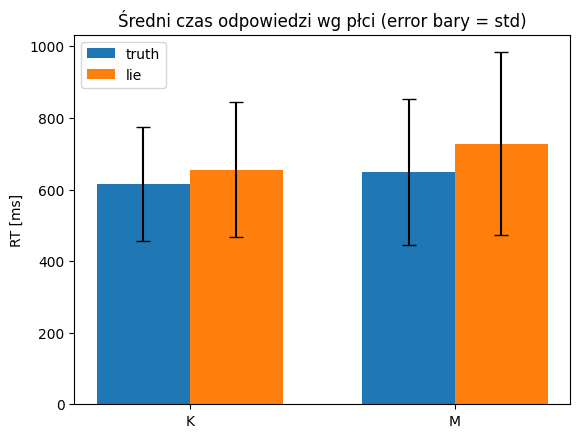

In [36]:
relevant_data_by_sex_and_is_truth_agg = (
    relevant_data_by_sex_and_is_truth_grp["duration"]
    .agg(["mean", "std", "sem"])
    .reset_index()
)

data_is_truth = relevant_data_by_sex_and_is_truth_agg[
    relevant_data_by_sex_and_is_truth_agg["is_truth"]
]
data_is_lie = relevant_data_by_sex_and_is_truth_agg[
    ~relevant_data_by_sex_and_is_truth_agg["is_truth"]
]

bar_width = 0.35
x = np.arange(2)
fig, ax = plt.subplots()
bars1 = ax.bar(
    x - bar_width / 2,
    data_is_truth["mean"],
    bar_width,
    yerr=data_is_truth["std"],
    capsize=5,
    label="truth",
)
bars2 = ax.bar(
    x + bar_width / 2,
    data_is_lie["mean"],
    bar_width,
    yerr=data_is_lie["std"],
    capsize=5,
    label="lie",
)
ax.set_xticks(x)
ax.set_xticklabels(("K", "M"))
ax.set_ylabel("RT [ms]")
ax.set_title("Średni czas odpowiedzi wg płci (error bary = std)")
ax.legend()

None

In [37]:
all_data_with_personal_data[["Wiek", "duration"]].corr()

,Wiek,duration
Wiek,1.000000,0.054547
duration,0.054547,1.000000


# Poprawne odpowiedzi

In [38]:
all_data_with_answer_correctness = all_data_no_timeouts.copy()
all_data_with_answer_correctness["is_answer_correct"] = (
    all_data_with_answer_correctness.apply(
        lambda x: x["response"] == x["correct_response"], axis=1
    )
)

all_data_with_answer_correctness.head()

,experiment_block,epochs,personal_data_field,personal_data_type,response,correct_response,duration,participant_id,is_answer_correct
0,HONEST / TRUE,"<Epochs | 1 events (all good), 0 – 0.832 s, b...",NAME,REAL,YES,YES,832.0,02F6BC66,True
1,HONEST / TRUE,"<Epochs | 1 events (all good), 0 – 1.004 s, b...",BIRTH_DATE,CELEBRITY,YES,YES,1004.0,02F6BC66,True
2,HONEST / TRUE,"<Epochs | 1 events (all good), 0 – 0.676 s, b...",NAME,RANDO,NO,NO,676.0,02F6BC66,True
3,HONEST / TRUE,"<Epochs | 1 events (all good), 0 – 0.98 s, ba...",HOMETOWN,RANDO,NO,NO,980.0,02F6BC66,True
4,HONEST / TRUE,"<Epochs | 1 events (all good), 0 – 0.7 s, bas...",NAME,RANDO,NO,NO,700.0,02F6BC66,True


In [39]:
incorrect = (
    all_data_with_answer_correctness[
        ~all_data_with_answer_correctness["is_answer_correct"]
    ][["participant_id", "is_answer_correct"]]
    .groupby(["participant_id"])
    .value_counts()
    .reset_index()[["participant_id", "count"]]
    .sort_values("count")
)

In [40]:
participants = all_data_with_answer_correctness["participant_id"].drop_duplicates()

participants_incorrect_answer_counts = pd.merge(
    participants,
    incorrect,
    how="left",
).fillna(0)
participants_incorrect_answer_counts["count"] = participants_incorrect_answer_counts[
    "count"
].astype("int32")

participants_incorrect_answer_counts.sort_values("count")

,participant_id,count
1,1299BF1A,0
11,E52DEA2D,1
8,ASD6DSA7,2
0,02F6BC66,2
9,BNFH348D,2
6,A3627947,3
12,FF0DC21C,4
7,A59D58F4,4
10,DAF24E45,6
2,2D663E30,6


In [41]:
incorrect_answers = all_data_with_answer_correctness[
    ~all_data_with_answer_correctness["is_answer_correct"]
]

In [42]:
incorrect_answers.groupby("experiment_block")[
    ["experiment_block", "is_answer_correct"]
].value_counts()

experiment_block  is_answer_correct
DECEITFUL / FAKE  False                36
DECEITFUL / TRUE  False                19
HONEST / FAKE     False                 6
HONEST / TRUE     False                23
Name: count, dtype: int64

In [43]:
incorrect_answers.groupby("personal_data_field")[
    ["personal_data_field", "is_answer_correct"]
].value_counts()

personal_data_field  is_answer_correct
BIRTH_DATE           False                30
HOMETOWN             False                28
NAME                 False                26
Name: count, dtype: int64

In [44]:
incorrect_answers.groupby("personal_data_type")[
    ["personal_data_type", "is_answer_correct"]
].value_counts()

personal_data_type  is_answer_correct
CELEBRITY           False                24
FAKE                False                18
RANDO               False                34
REAL                False                 8
Name: count, dtype: int64

In [45]:
incorrect_answers_as_int = all_data_with_answer_correctness[
    ["is_answer_correct", "duration"]
].copy()
incorrect_answers_as_int["is_answer_correct"] = incorrect_answers_as_int[
    "is_answer_correct"
].astype("int32")

incorrect_answers_as_int.groupby(["is_answer_correct"]).describe()

duration                                              \
                     count        mean         std      min        25%   
is_answer_correct                                                        
0                     84.0  712.665833  283.337409  367.997  516.00525   
1                   6396.0  672.764212  207.954750  356.003  547.99700   

                                              
                       50%       75%     max  
is_answer_correct                             
0                  604.004  825.0045  1716.0  
1                  615.998  728.0000  2000.0

niepoprawne odpowiedzi zajmowały średnio więcej czasu (chociaż dopiero powyżej mediany)

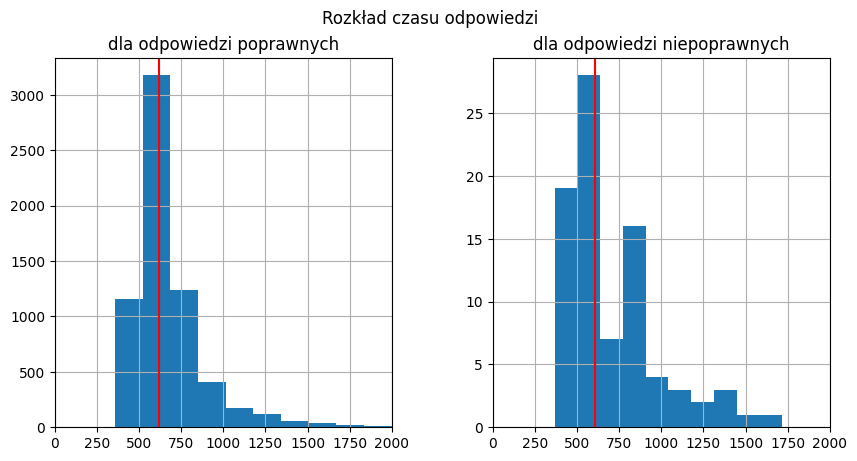

In [46]:
median_incorrect = 604.004
median_correct = 615.998

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)

fig.suptitle("Rozkład czasu odpowiedzi")

incorrect_answers_as_int[incorrect_answers_as_int["is_answer_correct"] == 1][
    ["duration"]
].hist(ax=axes[0])
axes[0].set_xlim(0, 2000)
axes[0].set_title("dla odpowiedzi poprawnych")
axes[0].axvline(x=median_correct, color="r")

incorrect_answers_as_int[incorrect_answers_as_int["is_answer_correct"] == 0][
    ["duration"]
].hist(ax=axes[1])
axes[1].set_xlim(0, 2000)
axes[1].set_title("dla odpowiedzi niepoprawnych")
axes[1].axvline(x=median_incorrect, color="r")

None

# Amplituda P300

In [47]:
def get_avg_eeg_for_block(df):
    trials_in_block = len(df)
    data = np.zeros((16, 500))

    for _, row in df.iterrows():
        epochs = row.epochs.get_data()[0]
        padded_epochs = np.pad(epochs, ((0, 0), (0, 500 - epochs.shape[1])))

        data += padded_epochs

    avg_data = data / np.full_like(data, trials_in_block)

    return np.repeat(avg_data, 4, axis=1)

In [48]:
channels = [
    "Fp1",
    "Fp2",
    "F3",
    "F4",
    "C3",
    "C4",
    "P3",
    "P4",
    "O1",
    "O2",
    "T3",
    "T4",
    "T5",
    "T6",
    "F7",
    "F8",
]

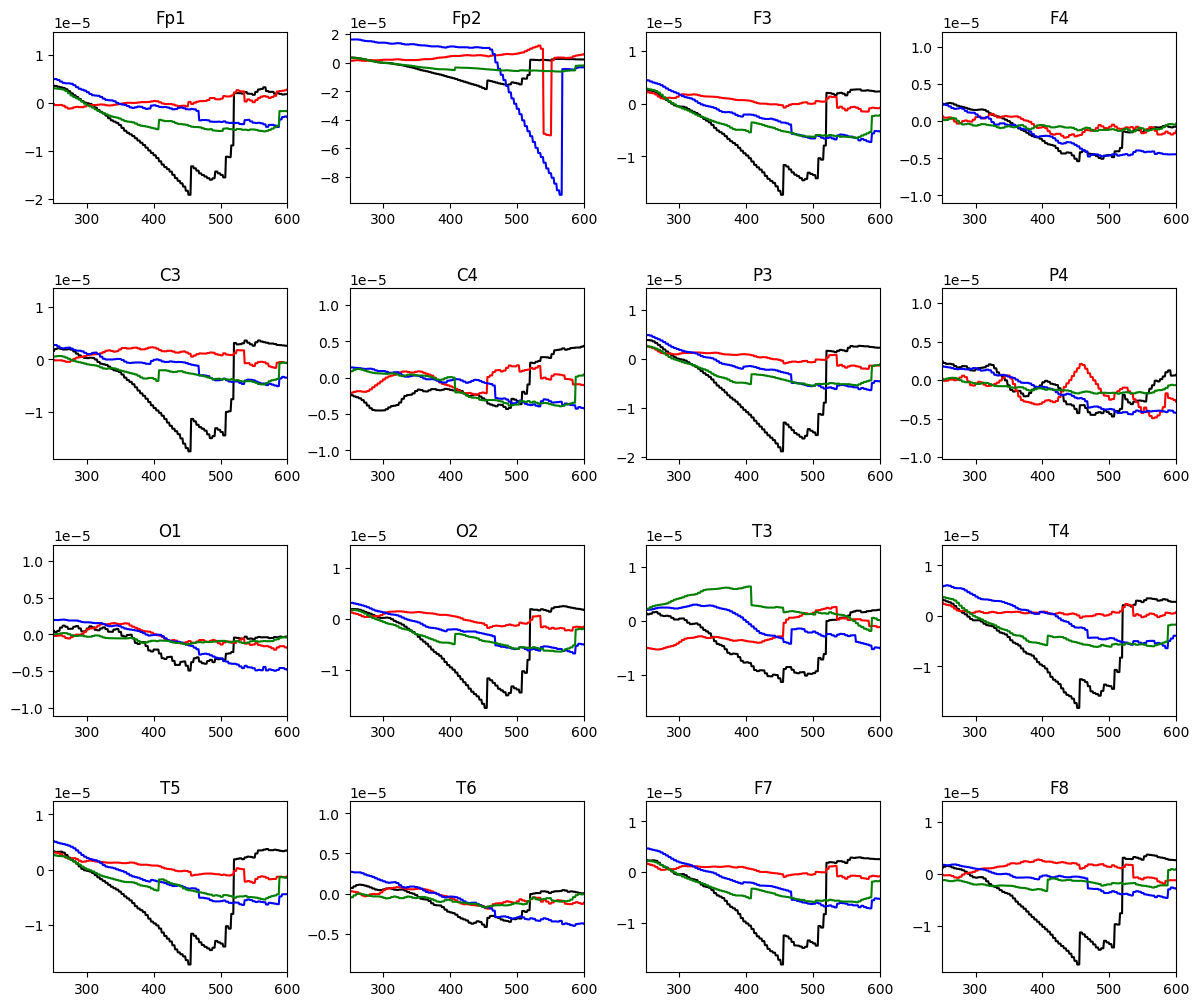

In [49]:
colors = {
    "HONEST / TRUE": "black",
    "DECEITFUL / TRUE": "red",
    "HONEST / FAKE": "blue",
    "DECEITFUL / FAKE": "green",
}

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
axes_flat = [ax for subax in axes for ax in subax]

for block, color in colors.items():
    df = relevant_data[relevant_data["experiment_block"] == block]
    eeg = get_avg_eeg_for_block(df)

    for channel_idx, ax in enumerate(axes_flat):
        ax.set_title(channels[channel_idx])
        ax.set_xlim(250, 600)
        ax.plot(-eeg[channel_idx], color=color, label=block)

None

# Częstotliwości

HONEST / TRUE


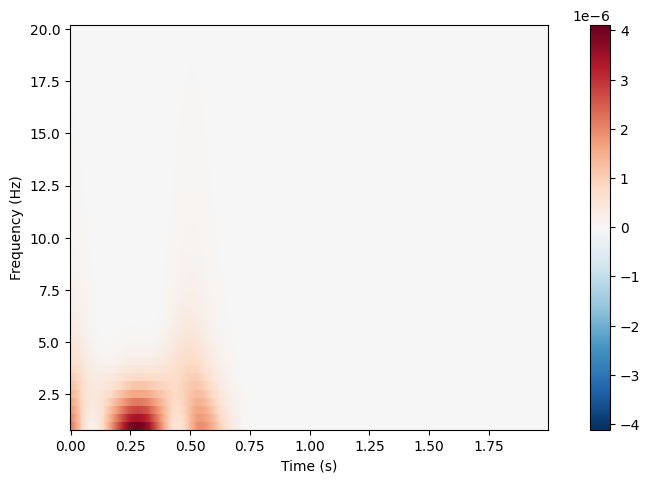

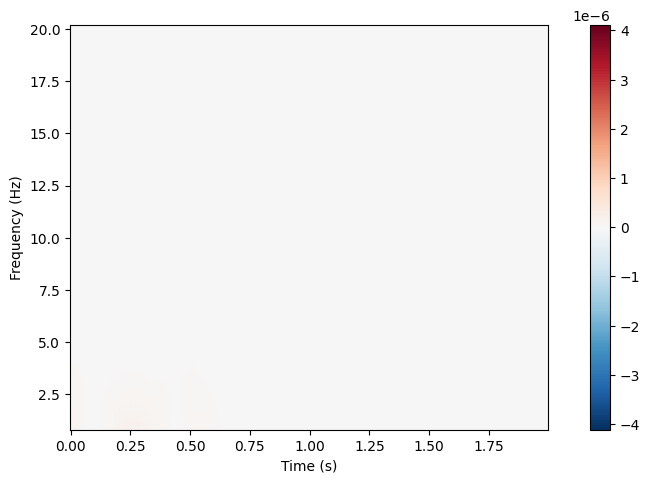

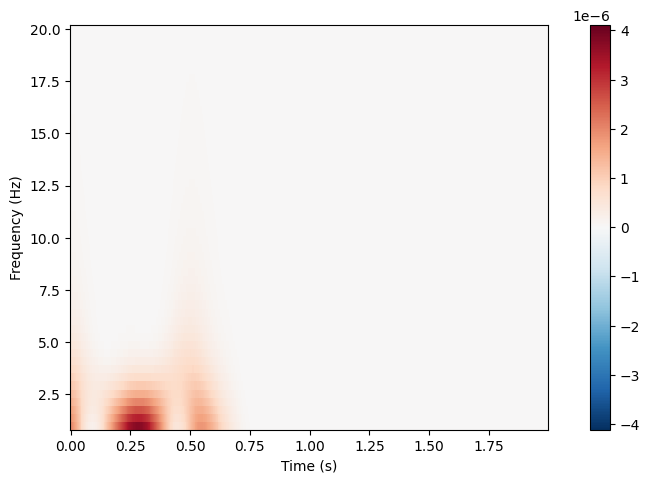

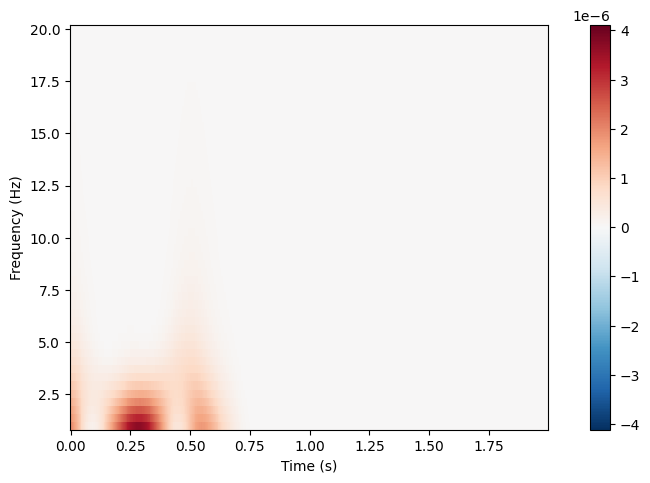

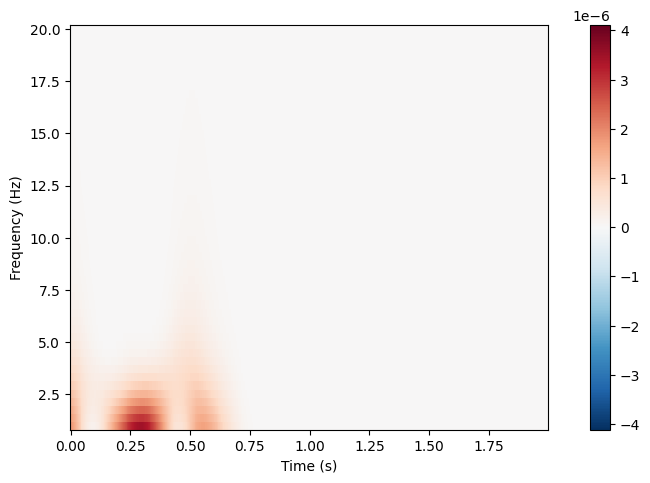

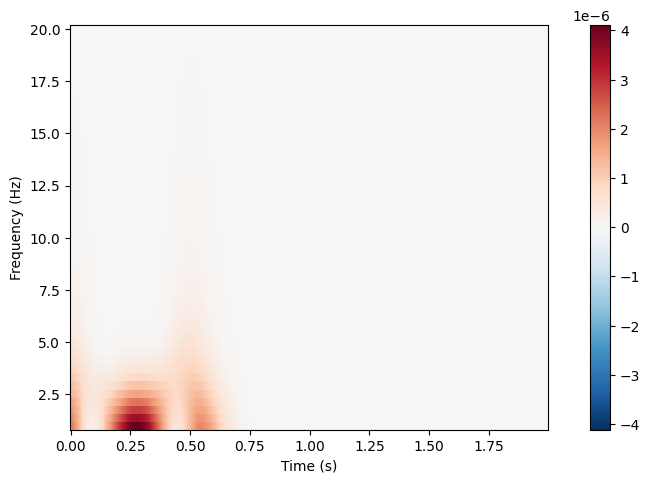

DECEITFUL / TRUE


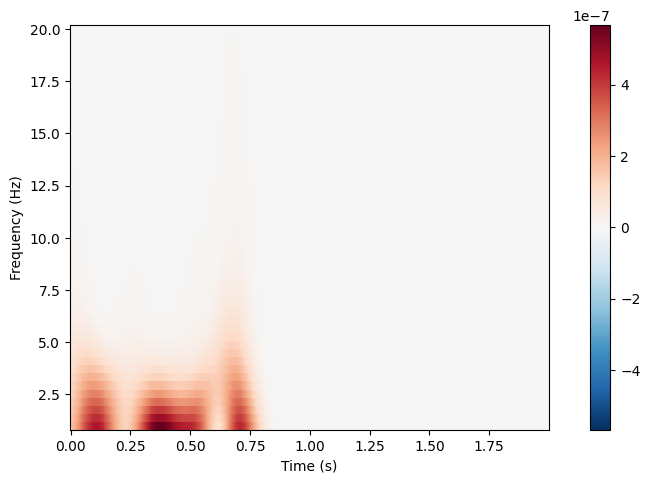

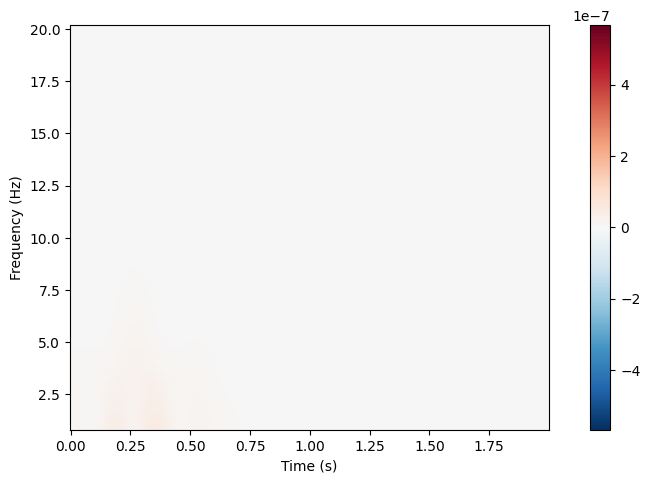

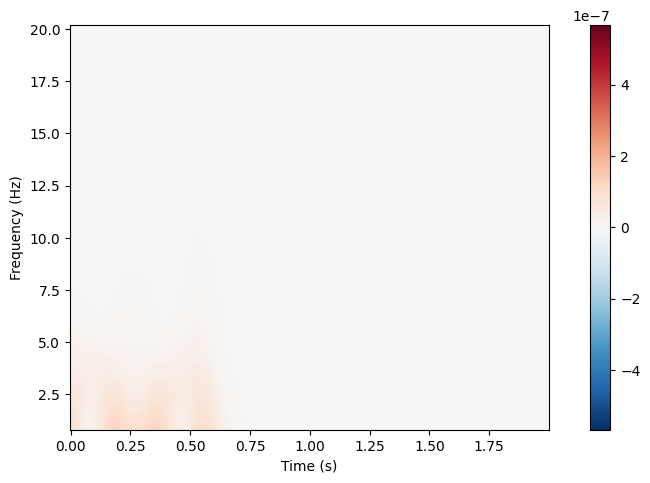

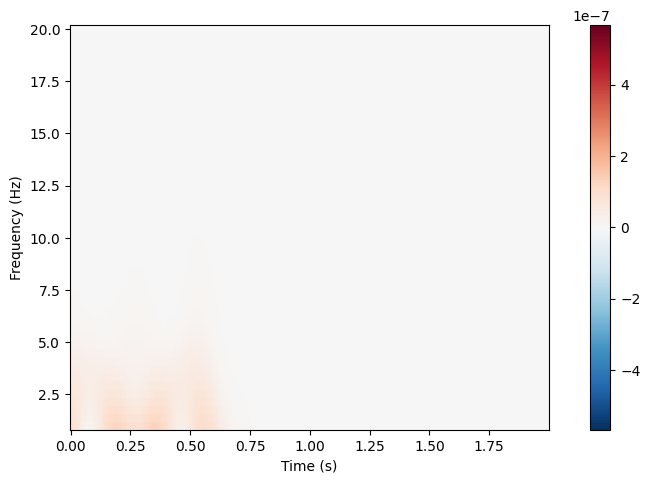

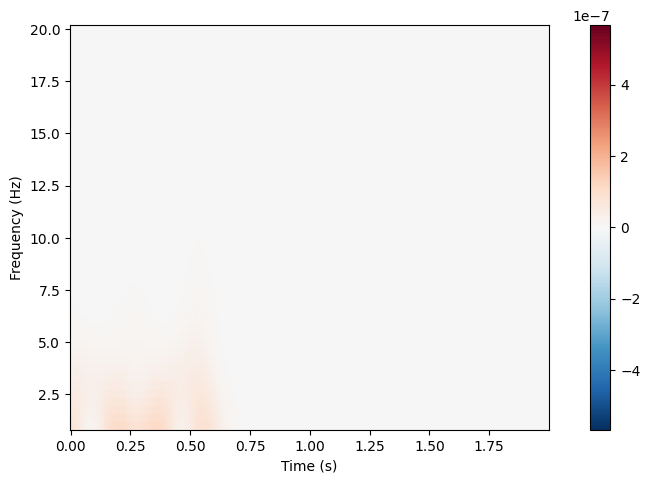

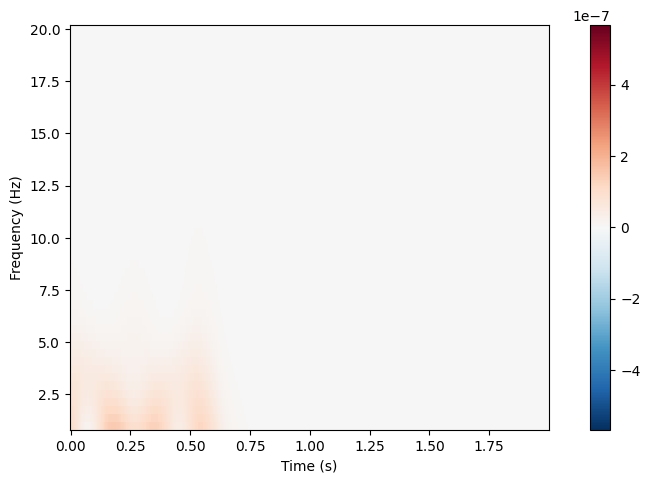

HONEST / FAKE


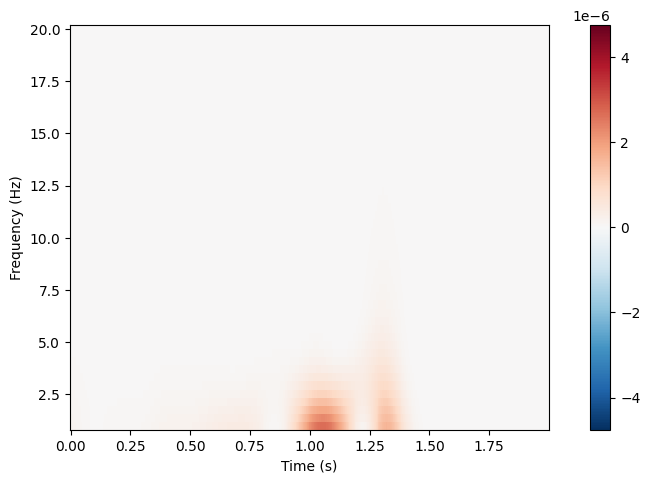

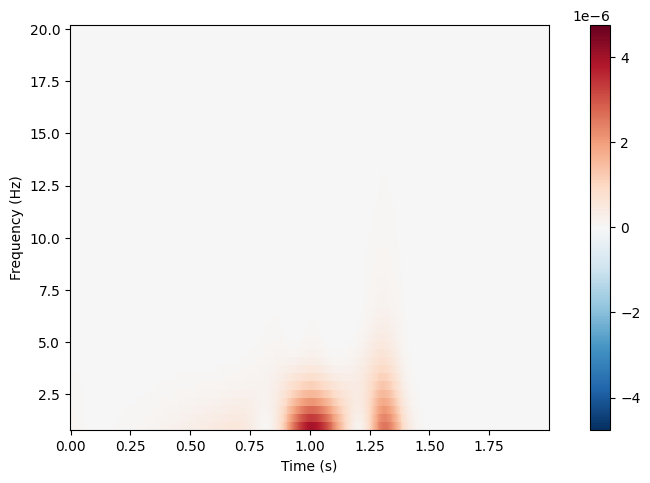

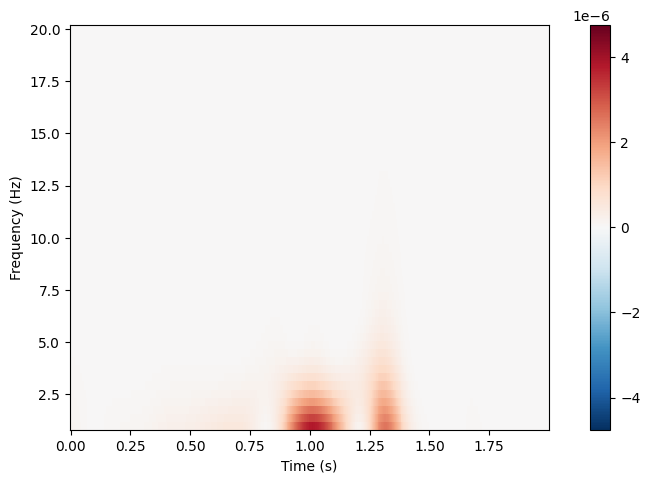

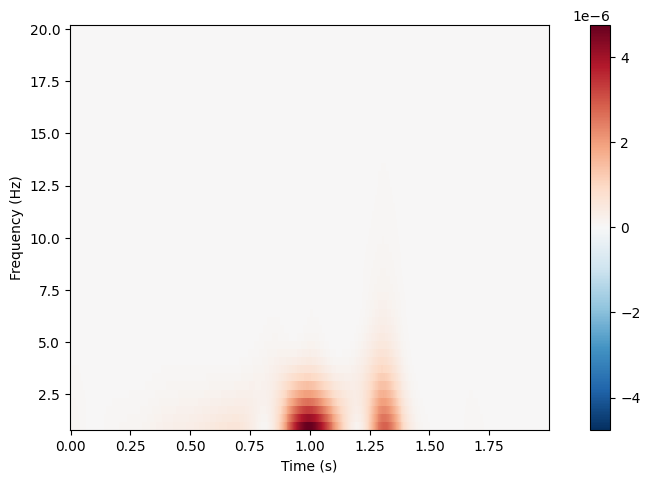

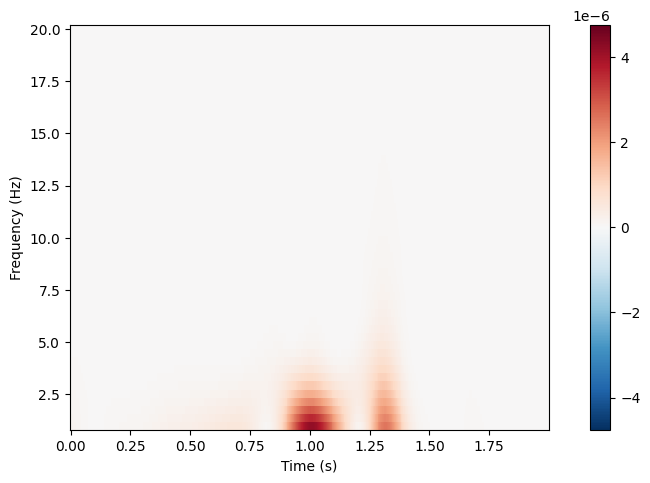

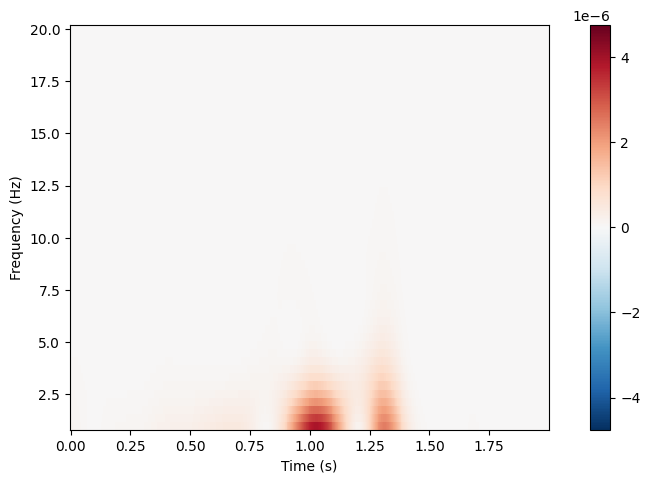

DECEITFUL / FAKE


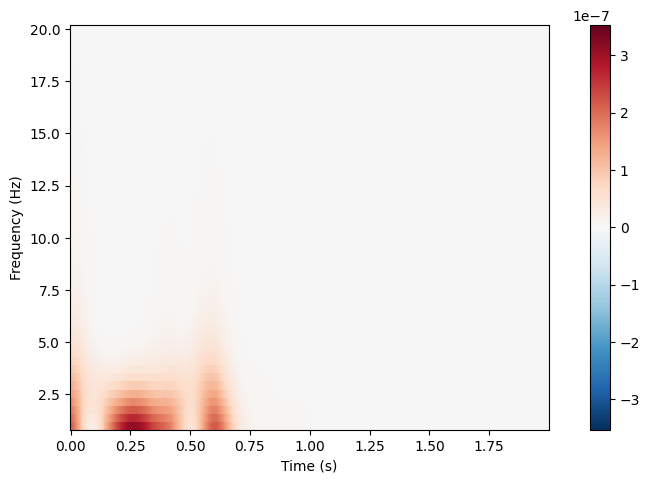

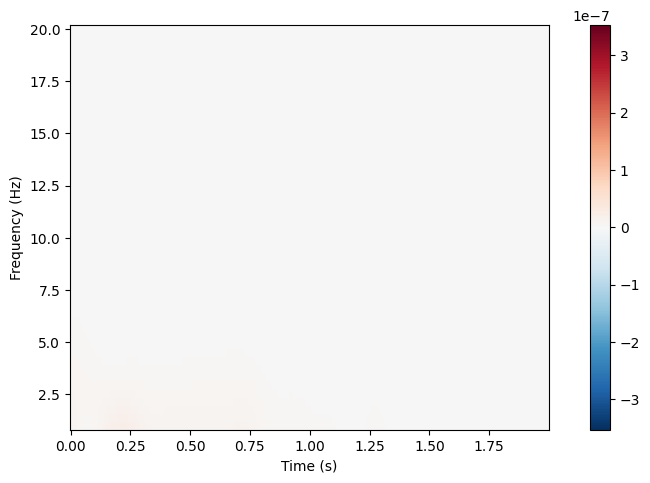

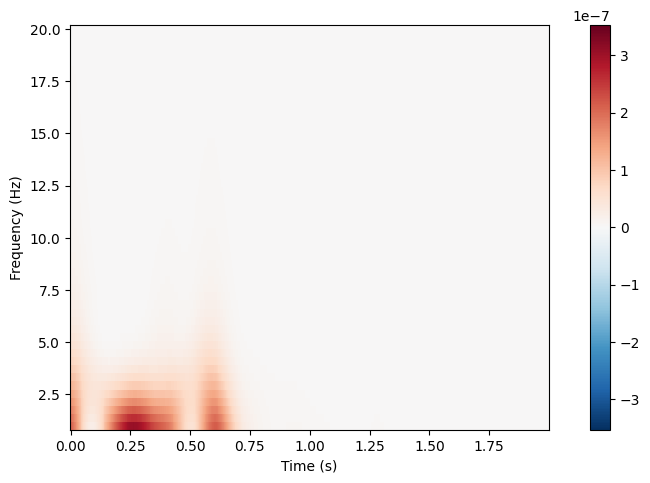

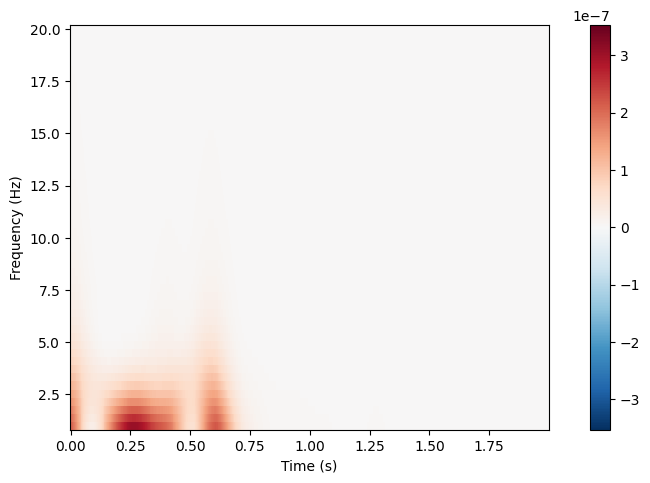

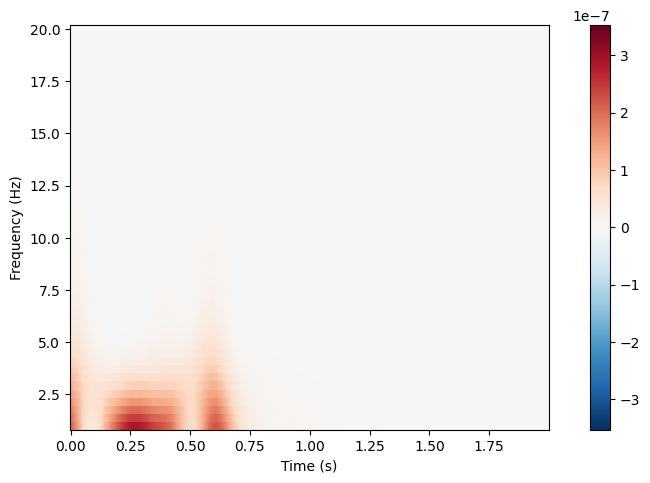

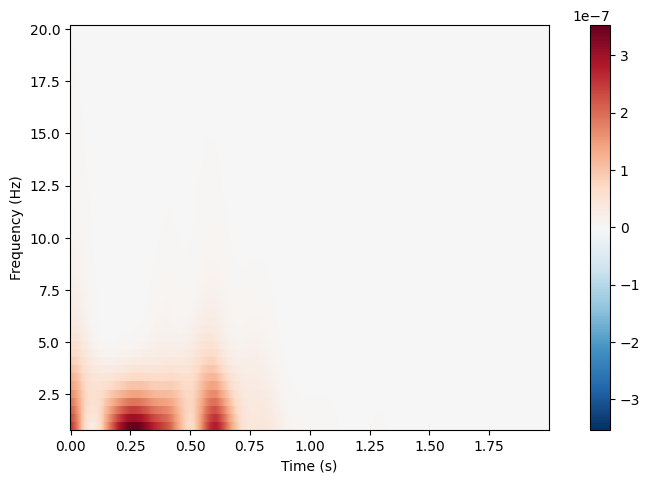

In [50]:
for block in colors:
    epochs_array = list(
        relevant_data[relevant_data["experiment_block"] == block]["epochs"]
    )
    padded_epochs_list = []
    max_length = 500

    for epochs in epochs_array:
        data = epochs.get_data()

        if data.shape[-1] < max_length:
            pad_width = max_length - data.shape[-1]
            padded_data = np.pad(
                data, pad_width=((0, 0), (0, 0), (0, pad_width)), mode="constant"
            )
            padded_epochs = mne.EpochsArray(padded_data, epochs.info, tmin=epochs.tmin)
        else:
            padded_epochs = epochs
        padded_epochs_list.append(padded_epochs)

    padded_epochs_combined = mne.concatenate_epochs(padded_epochs_list)

    frequencies = np.linspace(1, 20)
    n_cycles = frequencies / 2.0

    power = tfr_morlet(
        padded_epochs_combined,
        freqs=frequencies,
        n_cycles=n_cycles,
        return_itc=False,
        average=True,
    )

    print(block)
    power.plot([0, 3, 6, 9, 12, 15])